In [90]:
import pandas as pd
import seaborn as sns
import numpy as npm
import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.model_selection import train_test_split, cross_val_score # Etapa 4, seleccion y entrenamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder #Etapa 4, Normalizacion de los datos
from sklearn.impute import SimpleImputer #Etapa 4, gestion de valores nulos
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score # Etapa 6, Validación de métricas

from sklearn.linear_model import LogisticRegression, LinearRegression # Etapa 5, algoritmos a usar para construir nuestro modelo del modelo
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # Etapa 5,
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR


 1. Definicion del problema
2. Recoleccion de datos
3. Exploración y análisis de datos (EDA)
4. Selección y entrenamiento de modelos
5. Evaluación del modelo
6. Tunning y mejora
7. Despliegue del modelo (Out of scope)
8. Mantenimiento (Out of the scope)
9.

1. Predecir la sobrevivencia de los pasajeros del Titanic. Este problema es considerado un problema de clasificación (ya que se pretende clasificar por categoría, es decir, sobrevivieron ... si fuera de regresión, sería un valor continuo no discreto)

In [91]:
df = pd.read_csv('./datasets/titanic/titanic_train.csv')
df_test = pd.read_csv('./datasets/titanic/titanic_test.csv')
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    object 
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 83.7+ KB


In [93]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000


<Axes: >

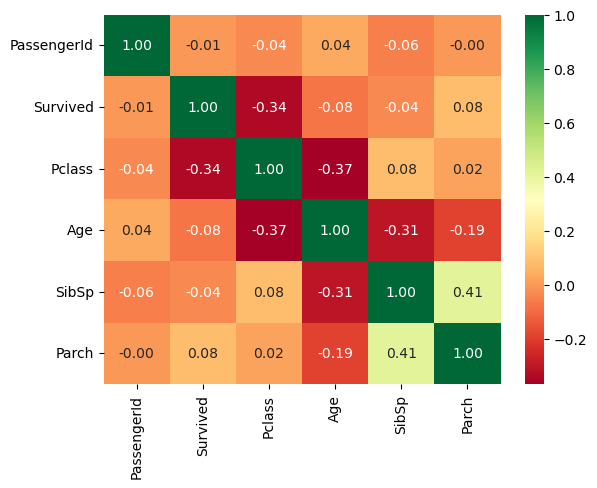

In [94]:
# df["cabin_null"] = df["Cabin"].isna()
# stats = {"conteo": ("Survived", len), "prob_survived": ("Survived", "mean")}
# df.groupby("cabin_null").agg(**stats)

sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="RdYlGn")

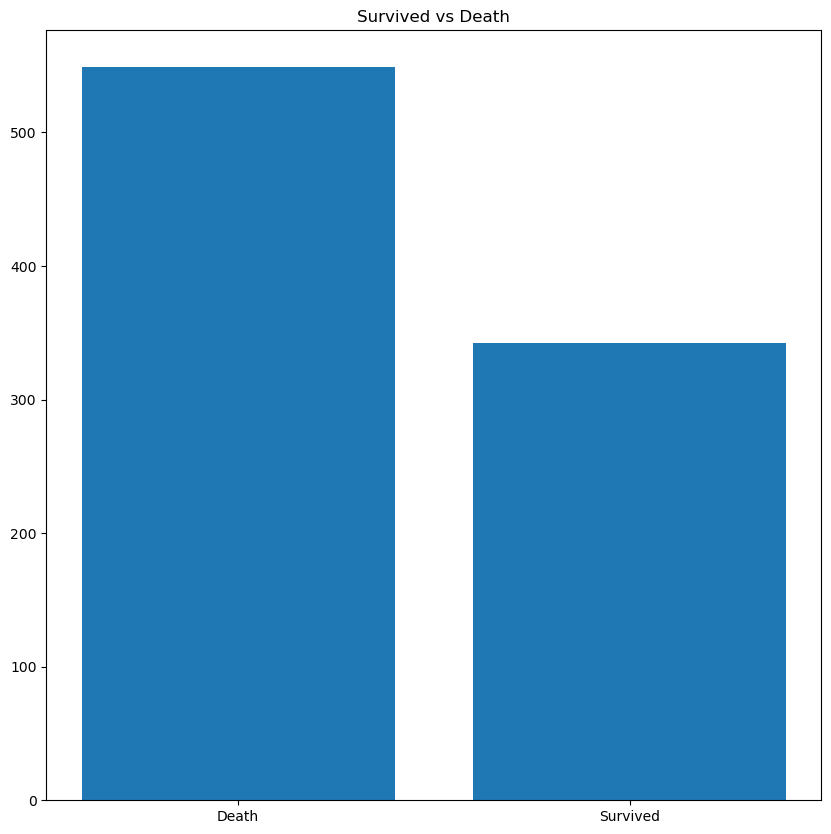

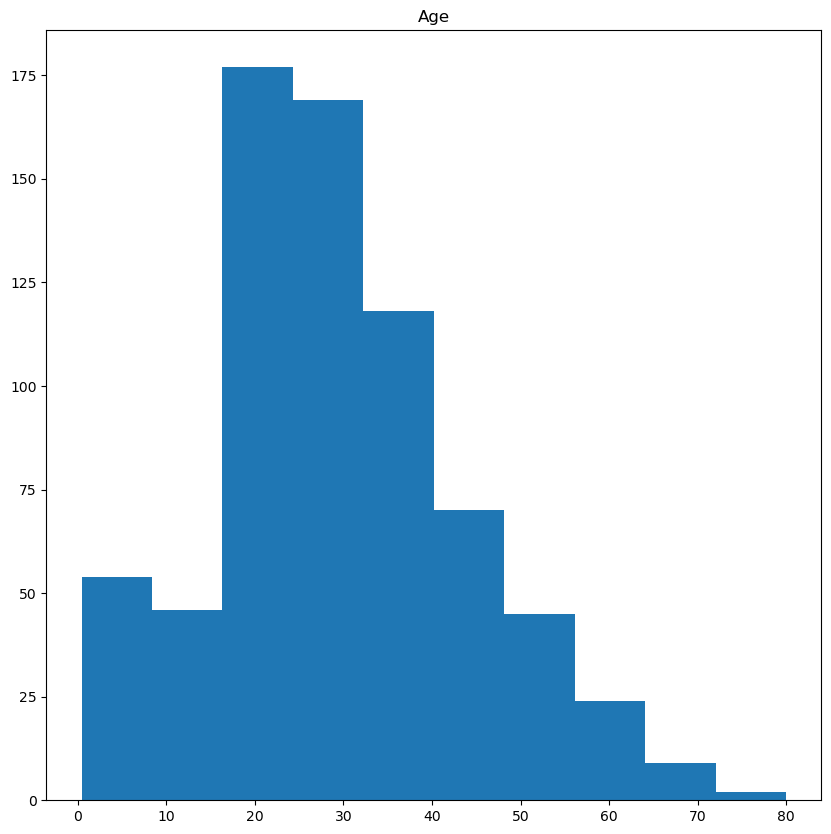

In [95]:
plt.figure(figsize = (10,10))
plt.bar(["Death", "Survived"], df["Survived"].value_counts())
plt.title("Survived vs Death")
plt.show()

plt.figure(figsize = (10,10))
plt.title("Age")
plt.hist(df["Age"].dropna())
plt.show()

In [96]:
df['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [97]:
df_clf = df.copy()
# Fill empty values with median for age
df_clf['Age'] = df_clf['Age'].fillna(df_clf['Age'].median())
# For Embarked, let's use the mode
df_clf['Embarked'] = df_clf['Embarked'].fillna(df_clf['Embarked'].mode()[0])
# for Sex, let's categorize it
df_clf['Sex'] = df_clf['Sex'].map({'male':0, 'female':1})
# for Embarked, let's categorize it
df_clf['Embarked'] = df_clf['Embarked'].map({'S':0, 'C':1, 'Q':2})
# remove unnecessary columns
df_clf.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1, inplace=True, errors='ignore')
#
df_clf['Fare'].unique()
# survived_drop = df_clf.drop(["Survived"], axis=1, errors='ignore')
# obj_cols = df_clf.select_dtypes(include='object').columns
# print("Columnas no numéricas:", list(obj_cols))
df_clf['Fare'] = (
    df_clf['Fare']
          .str.replace(r'\.', '', regex=True)   # quita miles
          .str.replace(',', '.', regex=False)   # pasa coma a punto
          .astype(float)
)

X_independent_variable = df_clf.drop(["Survived"], axis=1, errors='ignore') #Variable independiente
Y_dependent_variable = df['Survived'] # Variable dependiente, es decir, lo que quiero predecir

<Axes: >

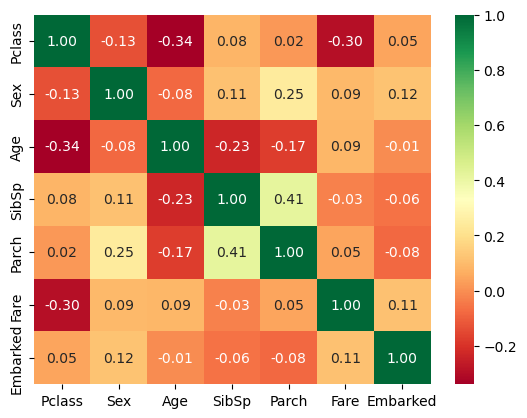

In [98]:
sns.heatmap(df_clf.corr() , annot=True, fmt=".2f", cmap="RdYlGn")

In [99]:
X_train, X_val, y_train, y_val = train_test_split(X_independent_variable,Y_dependent_variable, test_size=0.2, random_state=117)
logistic_regression = LogisticRegression()
modelo_svm = SVC()
logistic_regression.fit(X_train, y_train)
modelo_svm.fit(X_train, y_train)

/home/jresendiz/miniconda3/envs/CIC_AIDiploma2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC()